In [3]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns

matplotlib.rcParams.update({'font.size': 12})

# K157 Analysis Steps

1 - use "good" markers (based on visual estimation of staining; low background markers) to define 5 tissue compartments.

2 - calculate the signal for each marker (expression in correct compartment) e.g. for CD45, T-cell cytoplasm

3 - calculate the background for each marker (expression in incorrect compartment) - e.g. for CD45, tumor nuclei

4 - Visualize intensity distribution of early and late signal and background

## Load Data

In [4]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'
os.chdir(codedir)

In [5]:
#load positive (thresholded using AF subtracted)
df_pos = pd.read_csv(f'{codedir}/Data/Her2B-K157-6S_DAPI22Q_Nuclei1000_ManualPositive.txt',index_col=0,sep='\t')
df_pos['slide'] = [item.split('_')[0] for item in df_pos.index]
df_pos['scene'] = [item.split('_')[1] for item in df_pos.index]

#read in full features (all locations, cells)
df_mi = pd.read_csv(f'{codedir}/Data/features_Her2B-K157-6S_MeanIntensity.tsv',index_col=0,sep='\t')

df_mi['scene'] = [item.split('_')[0] for item in df_mi.index]

In [6]:
#Define tissue compartments

#define tumor and immune cell types
ls_tumor = ['CK19_Ring','CK5_Ring','Ecad_Ring','CK14_Ring'] # #'CK7_Ring'= poor quench, CK17_Ring = too many pos comapred to CK5 and CK14
ls_exclude = ['CD31_Ring','CD68_Ring','CD4_Ring'] 
df_pos['all-tumor'] = df_pos.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos['not-tumor'] = df_pos.loc[:,ls_exclude].sum(axis=1)>=1
df_pos['not-tumor-not-Tcell'] = df_pos.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos['tumor'] = (df_pos.loc[:,'all-tumor'].astype(int) -  df_pos.loc[:,'not-tumor'].astype(int))==1
df_pos['Endothelial'] = df_pos.loc[:,'CD31_Ring']

df_pos['Macrophage'] = (df_pos.loc[:,'CD68_Ring'].astype(int) - df_pos.loc[:,'CD31_Ring'].astype(int)) == 1


df_pos['Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['Stromal'] = (df_pos.loc[:,['tumor','Tcell','Macrophage','Endothelial']].sum(axis=1) ==0)
df_pos = df_pos.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)

#check
#df_pos.loc[:,['tumor','Tcell','Mac','Endothelial','Stromal']].sum().sum()
#len(df_pos)
#(df_pos.loc[:,['tumor','Tcell','Mac','Endothelial','Stromal']].sum(axis=1)!=1).sum()

In [7]:
#five compartments
df_pos.loc[:,['tumor','Tcell','Macrophage','Endothelial','Stromal']].sum()

tumor          30559
Tcell           7336
Macrophage      2055
Endothelial     8739
Stromal        13796
dtype: int64

In [8]:
#Annotate the compartment of signal and background for each marker
#dd key is forground, d key is cell type, d item is bg
dd_exclusive = {'Tcell':{ 'FoxP3_Nuclei':'tumor',
    'GRNZB_Nuclei':'tumor',
    'PD1_Ring':'tumor',
    'CD20_Ring':'tumor',
    'CD45_Ring':'tumor',
    'CD8_Ring':'tumor',
    'CD4_Ring':'tumor'},
                
'tumor':{'CK8_Ring':'Stromal',
    'CK5_Ring':'Stromal',
    'CK17_Ring':'Stromal',
    'HER2_Ring':'Stromal',
    'Ecad_Ring':'Stromal',
    'CK14_Ring':'Stromal',
    'ER_Nuclei':'Stromal',
    'PgR_Nuclei':'Stromal',
    'CK19_Ring':'Stromal'},
'Endothelial': {'CD31_Ring':'tumor',},
'Macrophage':{'CD68_Ring':'tumor',},
'Stromal':{'ColIV_Ring':'tumor',
    'aSMA_Ring':'Tcell',
    'PDPN_Ring':'tumor',
    #'ColI_Ring':'tumor', #different lot of antibody between early and late
    'CD44_Ring':'Endothelial',
    'Vim_Ring':'tumor',}
               }

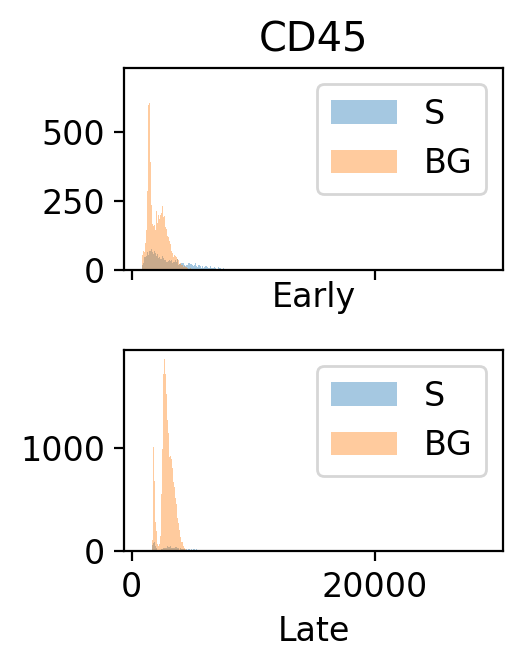

In [9]:
#produce single cell data/histograms

for s_fg, d_exclusive in dd_exclusive.items():
    fg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_fg]].index]
    for s_marker, s_bg in d_exclusive.items():    
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=True,dpi=200)
        ax=ax.ravel()
        #early
        bg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=500,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=500,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Early')
        #late
        se_fg = df_mi.loc[fg_index,f'{s_marker.split("_")[0]}b_{s_marker.split("_")[1]}']
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}b_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=500,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=500,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Late')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_histogram_{s_marker.split("_")[0]}.png')
        if s_marker != 'CD45_Ring':
            plt.close(fig)
